In [18]:
##簡單練習
import tensorflow as tf
import numpy as np

In [19]:
#建立溫度數據
temperature = np.arange(1, 15)
print(temperature)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [20]:
#參數設定
window_size = 3
batch_size = 2
shuffle_buffer = 10

In [21]:
#設定dataset格式
dataset = tf.data.Dataset.from_tensor_slices(temperature)
for element in dataset:
    print(element.numpy())

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [22]:
#window設定
dataset = dataset.window(window_size + 1, shift=1,drop_remainder=True)
for window in dataset:
    window_data = ' '.join([str(element.numpy()) for element in window])
    print(window_data)

1 2 3 4
2 3 4 5
3 4 5 6
4 5 6 7
5 6 7 8
6 7 8 9
7 8 9 10
8 9 10 11
9 10 11 12
10 11 12 13
11 12 13 14


In [24]:
#flatten
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
for element in dataset:
    print(element.numpy())

[1 2 3 4]
[2 3 4 5]
[3 4 5 6]
[4 5 6 7]
[5 6 7 8]
[6 7 8 9]
[ 7  8  9 10]
[ 8  9 10 11]
[ 9 10 11 12]
[10 11 12 13]
[11 12 13 14]


In [25]:
#切割x,y
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
print("\nAfter map:")
for x,y in dataset:
    print("x =", x.numpy(), "y =", y.numpy())


After map:
x = [1 2 3] y = 4
x = [2 3 4] y = 5
x = [3 4 5] y = 6
x = [4 5 6] y = 7
x = [5 6 7] y = 8
x = [6 7 8] y = 9
x = [7 8 9] y = 10
x = [ 8  9 10] y = 11
x = [ 9 10 11] y = 12
x = [10 11 12] y = 13
x = [11 12 13] y = 14


In [26]:
dataset = dataset.batch(batch_size).prefetch(1)
print("\nAfter batch and prefetch:")
for batch in dataset:
    print(batch)


After batch and prefetch:
(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [2, 3, 4]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 5])>)
(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[3, 4, 5],
       [4, 5, 6]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 7])>)
(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[5, 6, 7],
       [6, 7, 8]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([8, 9])>)
(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 7,  8,  9],
       [ 8,  9, 10]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([10, 11])>)
(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 9, 10, 11],
       [10, 11, 12]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([12, 13])>)
(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[11, 12, 13]])>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([14])>)


In [29]:
##進ML行銷售預測
import pandas as pd
#讀取資料
url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
data = pd.read_csv(url)
data.head()

,Date,Sales
0,2013-01-01,48.40
1,2013-01-02,49.63
2,2013-01-03,44.66
3,2013-01-04,56.70
4,2013-01-05,62.87


In [31]:
#設定time,sales
time = pd.to_datetime(data['Date'])
sales = data['Sales'].values

In [33]:
#設定訓練驗證數據
split_time = int(len(data) * 0.8)
time_train = time[:split_time]
time_val = time[split_time:]
x_train = sales[:split_time]
x_val = sales[split_time:]

In [35]:
#資料處理函式
def window_data(data,window_size, batch_size, shuffle_buffer_size):
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.window(window_size + 1, shift=1,drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1],window[-1]))
    data = data.batch(batch_size).prefetch(1)
    return(data)

In [42]:
#參數設定
window_size = 10
shuffle_buffer_size = 1000
batch_size = 32

dataset = window_data(x_train,window_size, batch_size, shuffle_buffer_size)

In [45]:
#模型訓練
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
    ])
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 214.6741
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 50.2081
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 41.2796
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 38.5390
Epoch 5/100
91/91 [==============================] - 0s 2ms/step - loss: 36.3139
Epoch 6/100
91/91 [==============================] - 0s 2ms/step - loss: 35.3932
Epoch 7/100
91/91 [==============================] - 0s 2ms/step - loss: 34.0817
Epoch 8/100
91/91 [==============================] - 0s 2ms/step - loss: 33.4576
Epoch 9/100
91/91 [==============================] - 0s 2ms/step - loss: 33.3747
Epoch 10/100
91/91 [==============================] - 0s 2ms/step - loss: 32.6351
Epoch 11/100
91/91 [==============================] - 0s 2ms/step - loss: 32.8134
Epoch 12/100
91/91 [==============================] - 0s 2ms/step - loss: 32.0634
Epoch 13/100
91/91 [====

In [46]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
    ])
model.compile(loss="mse",optimizer='adam')
model.fit(dataset,epochs=100)

Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 29.8339
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 29.2228
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 28.9853
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 28.8129
Epoch 5/100
91/91 [==============================] - 0s 2ms/step - loss: 29.7606
Epoch 6/100
91/91 [==============================] - 0s 2ms/step - loss: 29.1060
Epoch 7/100
91/91 [==============================] - 0s 2ms/step - loss: 28.8370
Epoch 8/100
91/91 [==============================] - 0s 2ms/step - loss: 28.8346
Epoch 9/100
91/91 [==============================] - 0s 2ms/step - loss: 29.1109
Epoch 10/100
91/91 [==============================] - 0s 2ms/step - loss: 29.0073
Epoch 11/100
91/91 [==============================] - 0s 2ms/step - loss: 29.8582
Epoch 12/100
91/91 [==============================] - 0s 2ms/step - loss: 29.0325
Epoch 13/100
91/91 [=====

In [79]:
##模型1
#驗證集設定
forecast = []
for time in range(len(sales) - window_size):
  forecast.append(model.predict(sales[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 15ms/step


In [81]:
#評估
def calculate_errors(y_true, y_pred):
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy()
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    return mse, mae

# 計算
calculate_errors(x_val, results)

Mean Squared Error: 27.417757
Mean Absolute Error: 4.1406775


(27.417757, 4.1406775)

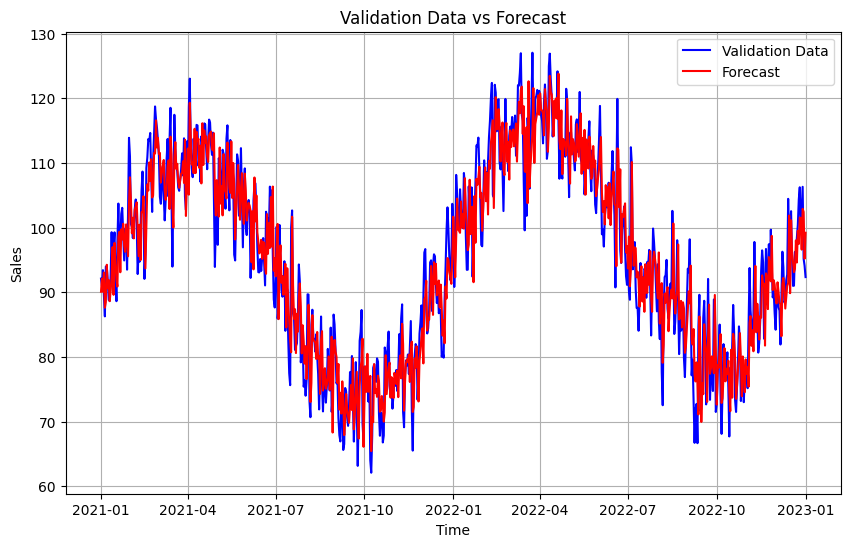

In [87]:
#畫圖
import matplotlib.pyplot as plt
def plot_forecast(valid_time, valid_data, forecast_data):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_time, valid_data, label="Validation Data", color='blue')
    plt.plot(valid_time, forecast_data, label="Forecast", color='red')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.title("Validation Data vs Forecast")
    plt.grid(True)
    plt.show()

plot_forecast(time_val, x_val, results)

In [88]:
##模型2
#驗證集設定
forecast2 = []
for time in range(len(sales) - window_size):
  forecast2.append(model2.predict(sales[time:time + window_size][np.newaxis]))

1/1 [==============================] - 0s 16ms/step


In [93]:
print(split_time,len(x_val),len(forecast2),len(sales))

2922 731 3643 3653


In [94]:
forecast2 = forecast2[split_time-window_size:]
results2 = np.array(forecast2)[:, 0, 0]

Mean Squared Error: 7098.1704
Mean Absolute Error: 83.21958


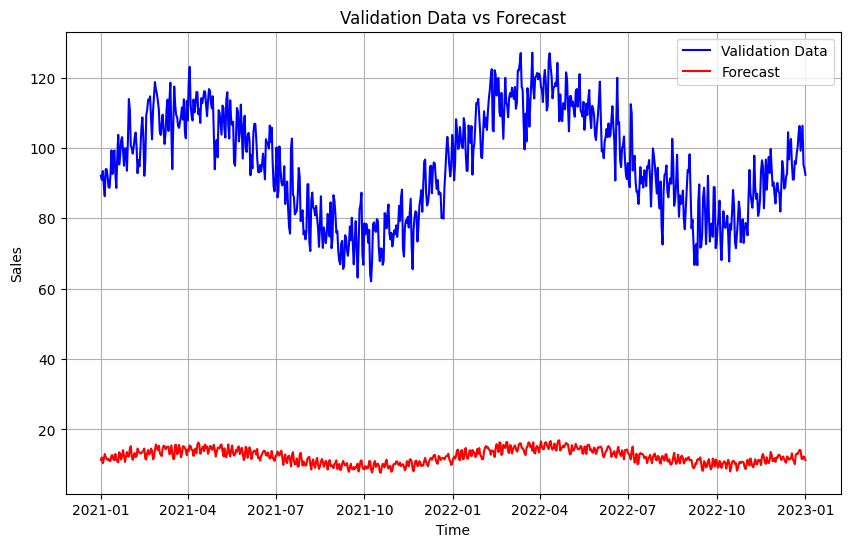

In [96]:
# 計算
calculate_errors(x_val, results2)
#畫圖
plot_forecast(time_val, x_val, results2)